In [1]:
from scipy.io import loadmat
from skimage.color import rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
data_dir = '/media/data_cifs_lrs/projects/prj_synchrony/data/BSR/BSDS500/data'
mat = np.squeeze(loadmat(os.path.join(data_dir, 'groundTruth/train/41004.mat'))['groundTruth'])
img = imread(os.path.join(data_dir, 'images/train/41004.jpg'))
segs = []
cts = []
for i in range(mat.shape[0]):
    segs.append(mat[i][0][0][0])
    cts.append(mat[i][0][0][1])

(40, 60)


(-0.5, 59.5, 39.5, -0.5)

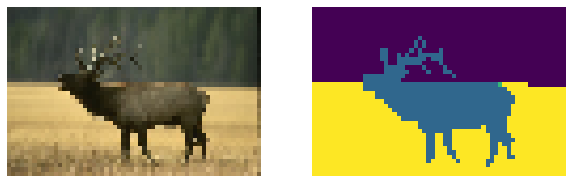

In [3]:
import cv2 as cv
h, w, _ = img.shape
s = 8
sm_img = cv.resize(img, (w//s, h//s))
sm_seg = cv.resize(segs[2], (w//s, h//s))
print(sm_seg.shape)
fig, axes = plt.subplots(1, 2, figsize=(10, 30))
axes[0].imshow(sm_img)
axes[1].imshow(sm_seg)
axes[0].axis('off')
axes[1].axis('off')



In [4]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

In [5]:
#import ipdb
def circular_moments(phases, masks, split=False, burn_in_prop=.5):
    """
    phases: shape [steps, ...]
    masks(one hot indicator): shape [num_groups, ...]
    split: if return synch and desynch separately
    burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
    """
    
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T) - 1
    masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_xx = xx.sum(-1) / group_size
    mean_yy = yy.sum(-1) / group_size
    mean_angles = torch.atan2(mean_yy, mean_xx)
    desynch = 0
    for m in np.arange(1, int(np.floor(num_groups/2.))+1):
#         K_m = 1 if m < int(np.floor(num_groups/2.)) + 1 else -1
        desynch += (1.0 / (2* num_groups * m**2)) * (torch.cos(m*mean_angles).sum(-1)**2 + torch.sin(m*mean_angles).sum(-1)**2)
    
    loss = synch + desynch
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

In [6]:
#import ipdb
def cohn_loss(phases, masks, split=False, burn_in_prop=.5):
    """
    phases: shape [steps, ...]
    masks(one hot indicator): shape [num_groups, ...]
    split: if return synch and desynch separately
    burn_in_prop: proportion of steps to be considered, steps before will not be added into loss
    """
    
    num_groups = masks.shape[0]
    group_size = masks.sum(1)
    group_size = torch.where(group_size == 0, torch.ones_like(group_size), group_size)
    T = phases.shape[0]
    
    burn_in_steps = int(burn_in_prop * T) - 1
    masked_phases = phases.unsqueeze(1) * masks # [steps, num_groups, ...]
    xx = torch.where(masks.bool(), torch.cos(masked_phases), torch.zeros_like(masked_phases))
    yy = torch.where(masks.bool(), torch.sin(masked_phases), torch.zeros_like(masked_phases))
    go = torch.sqrt((xx.sum(-1))**2 + (yy.sum(-1))**2) / group_size
    synch = 1 - go.sum(-1)/num_groups

    mean_xx = xx.sum(-1) / group_size
    mean_yy = yy.sum(-1) / group_size
    mean_angles = torch.atan2(mean_yy, mean_xx)
    phase_diffs = (mean_angles.unsqueeze(3) - mean_angles.unsqueeze(2))
    desynch = ((-1*torch.log(torch.abs(2*torch.sin(.5*(phase_diffs))) + 1e-5)) + np.log(2)).sum((1,2,3)) / (num_groups)**2
    
    loss = synch + desynch
    
    if split == True:
        return loss[burn_in_steps:,...].mean(), synch[burn_in_steps:,...].mean(), desynch[burn_in_steps:,...].mean()
    else:
        return loss[burn_in_steps:,...].mean()

In [7]:
class coupling_net_minju(torch.nn.Module):
    def __init__(self, feature_dim, h, w, num_hid_units=256):
        """
        Take in a set of embeddings of nodes and produce link weights. Weights will be produced separately, only the embeddings of two correponding nodes will be considered. Like relational networks.
        input: shape [batch_size, feature_dim]
        coupling(normalized unsymmetric): shape [batch_size, batch_size]
        """
        super(coupling_net_minju, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, feature_dim, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
        )
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2*(feature_dim+2), num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_hid_units, num_hid_units),
            torch.nn.BatchNorm1d(num_hid_units),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_hid_units,1,bias=False)
        )

        self.w=w#120
        self.h=h#80
        self.register_buffer('xx', torch.Tensor(np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[None,None,:,:] / w))
        self.register_buffer('yy', torch.Tensor(np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[None,None,:,:] / h))
        self.register_buffer('mask', torch.randperm(self.w * self.h))

    def forward(self, x, alpha=0.1, burnin_steps=150, num_steps=50, enable_noise=False):
        init_phase = torch.rand((self.w * self.h,)).float().unsqueeze(0).to(device) * 2 * np.pi
        
        x = self.features(x)
        if enable_noise:
            x = torch.randn_like(x)
        x = torch.cat([x, self.xx, self.yy],dim=1)
        b, c, h, w = x.size()
        x = x.view(b,c,-1)
        
#         Bx2 --> (bXb)x4 --> (bxb)x1 --> bxb
        
        with torch.no_grad():
            phase = init_phase
            for t in range(burnin_steps):
                mask = torch.randperm(self.w * self.h)[:128].to(device).detach()

                _x = torch.index_select(x,2,mask)
                _x = _x.permute(0,2,1).view(-1, c)
                batch_size = _x.shape[0]
                _x = torch.cat([_x[:,None].repeat(1,batch_size,1), _x[None,:].repeat(batch_size,1,1)],dim=2)

                #Infer couplings 
                coupling = self.layers(_x.view(-1, _x.shape[-1])).squeeze().reshape(batch_size, batch_size)
                coupling = torch.nn.functional.normalize(coupling, p=2, dim=1)


                _phase = torch.index_select(phase,1,mask)[0]

    #             phase_diffs = torch.sin(_phase.unsqueeze(-1) - _phase.unsqueeze(-2))
                phase_diffs = torch.matmul(coupling, torch.sin(_phase).unsqueeze(1)).squeeze(1) * torch.cos(_phase)\
                        - torch.matmul(coupling, torch.cos(_phase).unsqueeze(1)).squeeze(1) * torch.sin(_phase)

                delta = alpha * phase_diffs
                phase.index_add_(1, mask, delta.unsqueeze(0))
            
            
        phase_flow = [phase]
        for t in range(num_steps):
            mask = torch.randperm(self.w * self.h)[:128].to(device).detach()
#             for i in range(0,2400,200):
#             mask = self.mask[i:i+200]
#             print(cnt)
#             cnt+=1


            _x = torch.index_select(x,2,mask)
            _x = _x.permute(0,2,1).view(-1, c)
            batch_size = _x.shape[0]
            _x = torch.cat([_x[:,None].repeat(1,batch_size,1), _x[None,:].repeat(batch_size,1,1)],dim=2)

            #Infer couplings 
            coupling = self.layers(_x.view(-1, _x.shape[-1])).squeeze().reshape(batch_size, batch_size)
            coupling = torch.nn.functional.normalize(coupling, p=2, dim=1)

            phase = phase_flow[-1].clone()

            _phase = torch.index_select(phase,1,mask)[0]
            
#             phase_diffs = torch.sin(_phase.unsqueeze(-1) - _phase.unsqueeze(-2))
            phase_diffs = torch.matmul(coupling, torch.sin(_phase).unsqueeze(1)).squeeze(1) * torch.cos(_phase)\
                    - torch.matmul(coupling, torch.cos(_phase).unsqueeze(1)).squeeze(1) * torch.sin(_phase)
            
            delta = alpha * phase_diffs
            phase.index_add_(1, mask, delta.unsqueeze(0))
            phase_flow.append(phase)
            
        phase_flow = torch.stack(phase_flow[1:])
        _phase_flow = phase_flow.view(phase_flow.shape[0], 1, self.h, self.w)
        return _phase_flow
#         _phase_flow = torch.cat([torch.cos(_phase_flow), torch.sin(_phase_flow)],dim=1)
#         return self.decoder(_phase_flow), phase_flow

In [8]:
def phase_evol_ax(ax, phases, masks=None, save_name=None):
    phases = np.squeeze(np.array(phases, dtype=np.float32))
    phases = (phases % ((2*np.pi) + 2*np.pi)) % (2*np.pi)
    if masks is not None:
        group_num = masks.shape[0]
        annot_bool = [True] * group_num
        colors = {}
        for num in range(group_num):
            mean_angle = np.arctan2((np.sin(phases[-1]) * masks[0][num]).sum(),
                                    (np.cos(phases[-1]) * masks[0][num]).sum() + 1e-6)
            colors[num] = num*50#(mean_angle + 2 * np.pi) % (2 * np.pi) / (2 * np.pi)
        for i in range(phases.shape[1]):
            for num in range(group_num):
                if masks[num][i]:
                    ax.plot(phases[:, i], color=plt.cm.hsv(colors[num]), alpha=0.5)
                    if annot_bool[num]:
                        ax.text(phases.shape[0] + 0.01, phases[-1, i], 'group{}'.format(num+1),
                                 horizontalalignment='left', size='small', color=plt.cm.hsv(colors[num]))
                        annot_bool[num] = False
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')
        ax.set_ylim([0,2*np.pi])
    else:
        for i in range(phases.shape[1]):
            ax.set_plot(phases[:, i])
        ax.set_xlabel('Time')
        ax.set_ylabel('Phase')
        ax.set_title('Phase Evolution')

In [9]:
from sklearn.preprocessing import LabelBinarizer

# h, w = segs[2].shape
# sm_seg = cv.resize(segs[2], (w//8, h//8), cv.INTER_NEAREST)

# plt.figure()
# plt.imshow((sm_seg==2).astype(float))

print(np.unique(sm_seg))
lb = LabelBinarizer()
label = sm_seg.reshape(-1)
label_bin = lb.fit_transform(label)

label_bin[:,2]=0
label_bin = np.concatenate([label_bin[:,:2], label_bin[:,3:]],axis=1)

# print(label_bin.shape)
# plt.figure()
# plt.imshow(label_bin.reshape(40,60,3)[:,:,0])
# plt.figure()
# plt.imshow(label_bin.reshape(40,60,3)[:,:,1])
# plt.figure()
# plt.imshow(label_bin.reshape(40,60,3)[:,:,2])
# h, w, _ = sm_img.shape
# xx = np.repeat(np.linspace(0,w,w)[np.newaxis, :], h, axis=0)[:,:,None] / w
# yy = np.repeat(np.linspace(0,h,h)[:, np.newaxis], w, axis=1)[:,:,None] / h

# x = torch.Tensor(np.concatenate([sm_img, xx, yy], axis=2)).to(device) / 255.
x = torch.Tensor(sm_img).to(device) / 255.
y = torch.Tensor(label_bin).to(device)
x = x.permute(2,0,1).unsqueeze(0)
y = y.transpose(0,1)

print(y.shape)

[1 2 3 4]
torch.Size([3, 2400])


0 5.668667316436768 0.8392658233642578 4.673877239227295 53.31661605834961


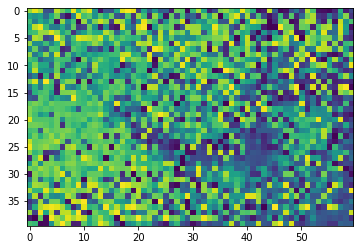

1 5.235596656799316 0.8221703171730042 4.423065185546875 13.009169578552246
2 5.591113567352295 0.8827352523803711 4.46837854385376 21.14945411682129
3 5.229096412658691 0.8496910333633423 4.376185894012451 11.187607765197754
4 5.256816387176514 0.7435246706008911 4.55409574508667 77.87995910644531
5 5.21628999710083 0.7487918138504028 4.586880207061768 9.529934883117676
6 5.127861022949219 0.8238275647163391 4.3201398849487305 3.4752655029296875
7 5.841220378875732 0.6355060935020447 4.742437362670898 39.452701568603516
8 4.990035057067871 0.631860077381134 4.33328104019165 4.170395851135254
9 5.416990280151367 0.7704707980155945 4.755186557769775 4.736297130584717
10 4.879493713378906 0.6444547176361084 4.234832286834717 3.398080825805664
11 4.864256381988525 0.62983238697052 4.244433403015137 3.8138535022735596
12 5.140387535095215 0.6182489395141602 4.3819146156311035 8.814925193786621
13 4.82451057434082 0.5206071734428406 4.260385990142822 4.651455402374268
14 4.823042869567871 0

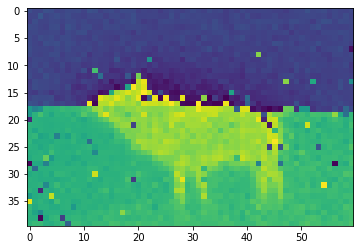

101 4.2860212326049805 0.06748366355895996 4.222464561462402 1.9385706186294556
102 4.395729064941406 0.0653831958770752 4.323118686676025 5.173556327819824
103 4.407530307769775 0.06359410285949707 4.331827163696289 5.050523281097412
104 4.366200923919678 0.1433500051498413 4.204710960388184 1.1411669254302979
105 4.4255499839782715 0.13147622346878052 4.2848076820373535 2.94296932220459
106 4.308228492736816 0.10296058654785156 4.197359561920166 1.723433494567871
107 5.080868721008301 0.1464824676513672 4.97924280166626 9.95908260345459
108 4.352444171905518 0.0822300910949707 4.250129222869873 2.580618381500244
109 4.29362678527832 0.09164458513259888 4.199112892150879 0.996932327747345
110 4.360539436340332 0.127685546875 4.212705612182617 3.5919301509857178
111 4.686864376068115 0.13069850206375122 4.478898525238037 7.350498199462891
112 4.380343914031982 0.08936220407485962 4.258904457092285 3.2936453819274902
113 4.4619646072387695 0.07386565208435059 4.348089694976807 5.6328787

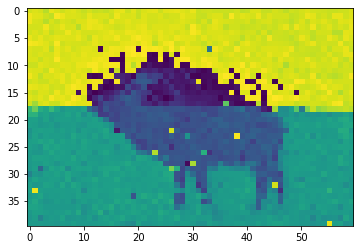

201 4.534242630004883 0.12150746583938599 4.346218585968018 3.4837594032287598
202 4.245934963226318 0.0678631067276001 4.179078578948975 2.909302234649658
203 4.26752233505249 0.07579231262207031 4.18904447555542 3.0694382190704346
204 4.27676248550415 0.10642623901367188 4.166971683502197 1.935937762260437
205 4.248597145080566 0.0720706582069397 4.175684452056885 2.348386764526367
206 4.26045560836792 0.07588732242584229 4.182009220123291 1.8078272342681885
207 4.25999641418457 0.06358528137207031 4.198526859283447 2.128216028213501
208 4.2573041915893555 0.05550110340118408 4.206294059753418 2.794243335723877
209 4.266579627990723 0.07442647218704224 4.19944429397583 2.4178662300109863
210 4.257804870605469 0.07692921161651611 4.185404300689697 1.5932797193527222
211 4.24172306060791 0.06281518936157227 4.180117130279541 0.6557367444038391
212 4.237229824066162 0.06300860643386841 4.173614501953125 0.5867505669593811
213 4.255186080932617 0.0793839693069458 4.174340724945068 1.8758

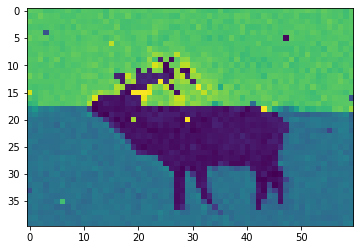

301 4.2173333168029785 0.05185747146606445 4.166099548339844 0.6417610049247742
302 4.218926429748535 0.05130136013031006 4.167081356048584 1.1462974548339844
303 4.222748756408691 0.05363398790359497 4.166009902954102 1.4280993938446045
304 4.221017360687256 0.05470973253250122 4.165403842926025 0.9929553270339966
305 4.217010021209717 0.05028212070465088 4.16487455368042 1.2184427976608276
306 4.215604305267334 0.048101961612701416 4.168037414550781 2.0435004234313965
307 4.236513614654541 0.06416869163513184 4.165972709655762 1.9186097383499146
308 4.209958553314209 0.04491698741912842 4.1653313636779785 0.6475549936294556
309 4.218904972076416 0.048140108585357666 4.169249534606934 1.0001076459884644
310 4.217165946960449 0.04842424392700195 4.169747352600098 1.8256169557571411
311 4.213272571563721 0.04000818729400635 4.172837257385254 0.8283461332321167
312 4.219476222991943 0.05147528648376465 4.167245864868164 0.5771229863166809
313 4.244301795959473 0.06733423471450806 4.17045

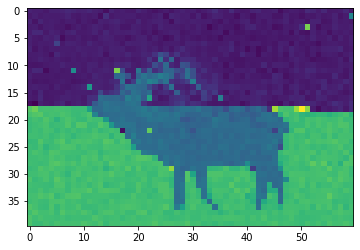

401 4.24756383895874 0.058193206787109375 4.166252613067627 1.522927165031433
402 4.447709083557129 0.07012224197387695 4.279433250427246 4.836802005767822
403 4.205885887145996 0.03088432550430298 4.1767706871032715 2.0099375247955322
404 4.213112831115723 0.04258185625076294 4.174766540527344 2.5484235286712646
405 4.214715480804443 0.04724729061126709 4.170717239379883 1.6948801279067993
406 4.214603900909424 0.03665286302566528 4.175251483917236 1.8178728818893433
407 4.238640785217285 0.05316495895385742 4.175258636474609 1.249448299407959
408 4.2521185874938965 0.044275760650634766 4.202974319458008 3.6592977046966553
409 4.253069877624512 0.040984928607940674 4.213371276855469 5.227694034576416
410 4.229157447814941 0.03920698165893555 4.196648120880127 3.339318037033081
411 4.450259208679199 0.06630021333694458 4.344454288482666 7.53529691696167
412 4.203734874725342 0.03389251232147217 4.169380187988281 1.7135013341903687
413 4.199931621551514 0.034660935401916504 4.1652069091

In [16]:

alpha = 0.2#0.2
burnin_steps=200#150
num_steps=50
num_epochs = 500
lr = 1e-4
net = coupling_net_minju(feature_dim=64, h=40, w=60, num_hid_units=256).to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)
for epoch in range(num_epochs):
    phases = net(x, alpha=alpha, burnin_steps=burnin_steps, num_steps=num_steps)
    b, c, h, w = phases.size()
    loss, synch, desynch = cohn_loss(phases.view(b, c, -1), y, burn_in_prop=0, split=True)
    
#     loss = loss / num_steps
    optim.zero_grad()
    loss.backward()
    norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
    print(epoch, loss.item(), synch.item(), desynch.item(), norm.item())
    optim.step()
    if epoch % 100 == 0:
        plt.figure()
        plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi))
        plt.savefig('%d.png' % epoch)
        plt.show()
        plt.close()
#         print(epoch, loss.item(), synch.item(), desynch.item(), norm.item())

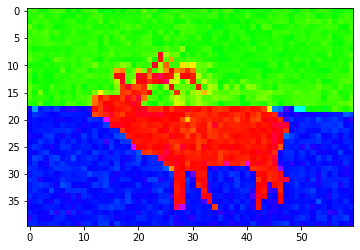

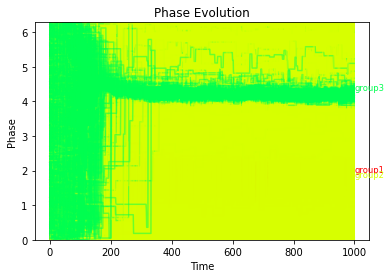

<Figure size 432x288 with 0 Axes>

In [17]:
# run Kuramoto dynamics over 1000 steps (200 steps for training)
with torch.no_grad():
    phases = net(x, alpha=alpha, burnin_steps=0, num_steps=1000, enable_noise=False)

b, c = phases.shape[:2]
plt.figure()
plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
plt.show()
plt.close()
fig, ax = plt.subplots()
# print(latent_phases.shape)
plt.figure()
phase_evol_ax(ax, (phases).view(b, c, -1).cpu().data.numpy(), y.cpu().data.numpy())

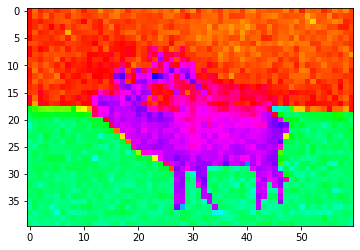

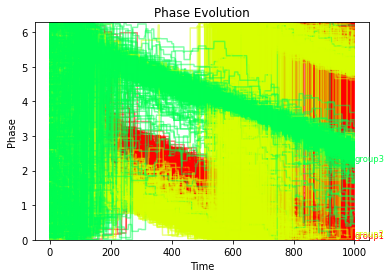

<Figure size 432x288 with 0 Axes>

In [22]:
# converting grayscale
with torch.no_grad():
#     phases = net(torch.flip(x,dims=[3]), alpha=alpha, burnin_steps=0, num_steps=1000, enable_noise=False)
    phases = net(x.mean(1,keepdim=True).repeat(1,3,1,1), alpha=alpha, burnin_steps=0, num_steps=1000, enable_noise=False)

b, c = phases.shape[:2]
plt.figure()
plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
plt.show()
plt.close()
fig, ax = plt.subplots()
# print(latent_phases.shape)
plt.figure()
phase_evol_ax(ax, (phases).view(b, c, -1).cpu().data.numpy(), y.cpu().data.numpy())

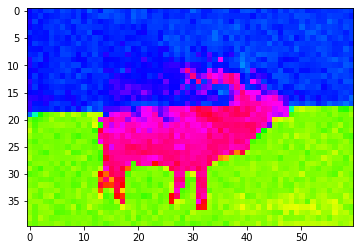

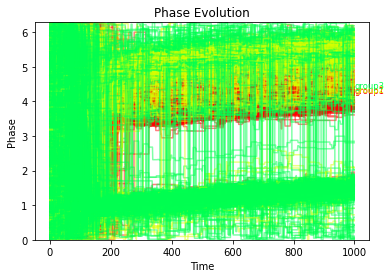

<Figure size 432x288 with 0 Axes>

In [21]:
# horizontal flipping
with torch.no_grad():
    phases = net(torch.flip(x,dims=[3]), alpha=alpha, burnin_steps=0, num_steps=1000, enable_noise=False)

b, c = phases.shape[:2]
plt.figure()
plt.imshow(phases[-1,0].cpu().data.numpy() % (2*np.pi), cmap=plt.get_cmap('hsv'))
plt.show()
plt.close()
fig, ax = plt.subplots()
# print(latent_phases.shape)
plt.figure()
phase_evol_ax(ax, (phases).view(b, c, -1).cpu().data.numpy(), y.cpu().data.numpy())

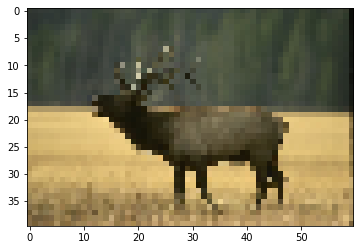

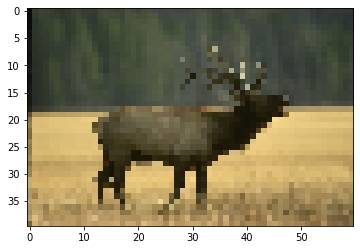

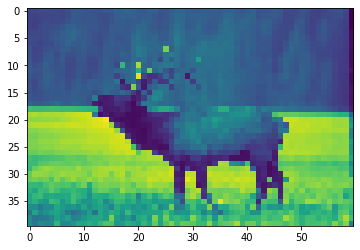

In [49]:
plt.figure()
plt.imshow(x[0].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(torch.flip(x,dims=[3])[0].permute(1,2,0).cpu().numpy())
plt.figure()
plt.imshow(x.mean(1,keepdim=True)[0].permute(1,2,0).cpu().numpy())